# RTED-TDS Co-Sim

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted`` has attributes ``rted`` and ``dcopf``. The two attributes are the RTED model and standard DCOPF model.
The two model can be built by methods ``build_rted()`` and ``build_dcopf()``, respectively. The results can be accessed by method ``get_res()``, after successfully solved the ``rted`` or ``dcopf``.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, amtplotlib, scipy

## Import case

In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from jams import rted2, dcopf, rted3

In [2]:
from ev_ssm import ev_ssm

Package version

In [3]:
print(andes.__version__)
print(pp.__version__)

1.7.0.post172.dev0+gb99041fa
2.8.0


EV aggregator

In [4]:
sse = ev_ssm(ts=10, N=10000, step=1, tp=100,
             lr=0.1, lp=100, seed=2022, name="EVA")
sse.load_A("Aest.csv")

EVA: ts=10[H], 10000 EVs, Total Q=250.12 MWh
Online 1983, Q=49.73 MWh, SoC=0.9834
Power(MW): Pt=-0.3613, Pc=-0.3613, Pd=-0.0
Ctrl: 0=1921; 1=62; 
EVA: Load A from Aest.csv.


Import ADNES case

In [5]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=False,
                 default_config=False)

Working directory: "/home/jwang175/andes/jwang/notes2"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1030 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0448 seconds.


Set output mode as 'manual'

In [6]:
ssa.TDS.config.save_mode = 'manual'

Set load as constant load.

In [7]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [8]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

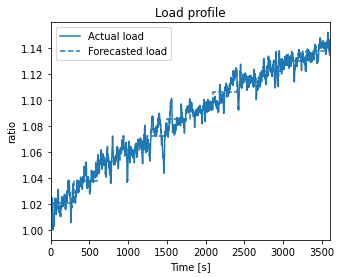

In [9]:
# --- get ANDES load ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale d_syn ---
ddata_path = '/case/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 50
# The equation is tuned for ieee39
# original: (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1
d_syn['s10'] = ratio*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].var() + 1

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [10]:
ev_idx = 'PV_10'

In [11]:
# --- set up EV generator data ---
ssa.PV.set(src='p0', idx=ev_idx, attr='v', value=sse.Ptc)
ssa.PV.set(src='pmax', idx=ev_idx, attr='v', value=sse.Pu)
ssa.PV.set(src='pmin', idx=ev_idx, attr='v', value=sse.Pl)

True

In [12]:
# --- conversion ---
ssp = to_pandapower(ssa)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, G1-11. G10 EV, G11 Slack
linearcost = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.5]

gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1104 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221393901e-09
Converged in 5 iterations in 0.0086 seconds.
Report saved to "ieee39_ev2_out.txt" in 0.0020 seconds.
Power flow results are consistent. Conversion is successful.


True

In [13]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_1,29,436.086385,1.035534,100.0,-58.084,183.8160,1.0,False,True,0.0,None,True,200.000000,1500.000000,NaN
1,PV_2,30,645.999998,1.013246,100.0,-122.665,515.7648,1.0,False,True,0.0,None,True,150.000000,900.000000,NaN
2,PV_3,31,724.999998,1.020528,100.0,-180.218,536.0664,1.0,False,True,0.0,None,True,100.000000,800.000000,NaN
3,PV_4,32,651.999998,1.013430,100.0,-213.780,657.8496,1.0,False,True,0.0,None,True,100.000000,700.000000,NaN
4,PV_5,33,520.000000,1.019109,100.0,-188.028,733.7940,1.0,False,True,0.0,None,True,100.000000,700.000000,NaN
5,PV_6,34,690.000000,1.060000,100.0,-234.972,712.5456,1.0,False,True,0.0,None,True,100.000000,800.000000,NaN
6,PV_7,35,590.000000,1.060000,100.0,-249.132,682.0464,1.0,False,True,0.0,None,True,100.000000,700.000000,NaN
7,PV_8,36,330.000000,1.013996,100.0,-216.122,532.1616,1.0,False,True,0.0,None,True,100.000000,700.000000,NaN
8,PV_9,37,780.000000,1.052803,100.0,-356.889,1001.7300,1.0,False,True,0.0,None,True,100.000000,1000.000000,NaN
9,PV_10,37,-36.128532,1.052803,100.0,0.000,0.0000,1.0,False,True,0.0,None,False,-38.104337,1144.862135,NaN


Build RTED instance ``ssd``

In [14]:
ssd = rted2()
ssd.from_andes(ssa)

# set EV generator as uncontrollable
ssd.gen.ctrl.iloc[9] = 0

# set EV geenrator as type2
prumax = sse.g_frc()[0]
prdmax = sse.g_frc()[1]
ssd.def_type2([ev_idx], [prumax], [prdmax])

# set ramp5
ramp_hour = [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999]
# ramp_hour = [80, 80, 80, 50, 50, 50, 30, 30, 30, 999, 30]
ssd.gen.ramp5 = np.array(ramp_hour) * 10 / 12 / ssd.mva

# set cost
ssd.cost.c1 = linearcost

# set SFR cost of EV lower than SynGen
ssd.cost.cru = 0.1
ev_loc = ssd.cost[ssd.cost.idx == ev_idx].index[0]
ssd.cost.cru.iloc[ev_loc] = 0.0999
ssd.cost.crd = ssd.cost.cru

# update p_pre from DCOPF results
ssd.set_p_pre()

# sovle the model
ssd.get_res()

Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0082 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221393901e-09
Converged in 5 iterations in 0.0099 seconds.
Report saved to "ieee39_ev2_out.txt" in 0.0035 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x667f9866
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 54 rows and 3 columns
Presolve time: 0.00s
Presolved: 15 rows, 14 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   8.006238e+01   0.000000e+00      0s
      15    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.
No RegUp requirement data (``du``), set to 0.
No RegDn requirement data (``dd``), set to 0.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xcb6acfe0
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [2e-02, 6e+01]
Presolve removed 102 rows and 25 columns
Presolve time: 0.00s
Presolved: 15 rows, 12 columns, 118 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   8.196400e+01   0.000000e+00      0s
      13    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve RTED.


,gen,pg,pru,prd,bu,bd
0,PV_1,12.591757,0.0,0.0,0.0,0.0
1,PV_2,6.180955,0.0,0.0,0.0,0.0
2,PV_3,8.000000,0.0,0.0,0.0,0.0
3,PV_4,5.851096,0.0,0.0,0.0,0.0
4,PV_5,7.000000,0.0,0.0,0.0,0.0
5,PV_6,4.800000,0.0,0.0,0.0,0.0
6,PV_7,3.501478,0.0,0.0,0.0,0.0
7,PV_8,7.000000,0.0,0.0,0.0,0.0
8,PV_9,1.000000,0.0,0.0,0.0,0.0
9,PV_10,-0.361285,0.0,0.0,0.0,0.0


Benchmark Standard DCOPF of ``ssd`` with ``ssp``

In [15]:
pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ssdc = ssd.to_dcopf()
gb_res = ssdc.get_res()
ppres['p_mw(GB)'] = ssp.sn_mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")
ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x667f9866
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 54 rows and 3 columns
Presolve time: 0.01s
Presolved: 15 rows, 14 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   8.006238e+01   0.000000e+00      0s
      15    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.


pp cost=6006.400000039854, gb cost=60.063999999999986


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,953.402639,92.622757,16.583158,1.0,1259.175652
1,687.610489,311.488301,7.878849,1.0,618.095512
2,597.122892,149.407550,9.151475,1.0,800.000000
3,525.090559,131.140357,8.859934,1.0,585.109579
4,525.168459,146.559740,8.456003,1.0,700.000000
5,598.216351,227.749422,11.793871,1.0,480.000000
6,520.488932,63.219181,14.641223,1.0,350.147789
7,426.782305,-27.585564,12.230323,1.0,700.000000
8,758.645906,118.941642,14.220500,1.0,100.000000
9,-36.128532,0.000000,14.220500,1.0,-36.128532


## Prepare

### Make link table

In [16]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


### Define functions used in loop

In [17]:
# --- def functions ---
def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    ratio = 30
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(load_ci[0] - load_exp) * ratio
    load_u = abs(load_ci[1] - load_exp) * ratio
    return load_u, load_d, load_exp

## Define param

In [18]:
# --- constants ---
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.2
ace_res = pd.DataFrame()

# initial load
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

Check if RTED converge in all 12 intervals

In [19]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(400):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed)
        ssp.load['p_mw'] = ssa_p0 * ssp.sn_mva * load_exp
        ssp.load['q_mvar'] = ssa_q0 * ssp.sn_mva * load_exp
        ssd.load['p0'] = ssa_p0 * load_exp
        ssd.update_dict()

        # --- RTED, update gen limits after SFR ---
        if end_time > 0:
            # get pe from TDS and sort
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2,
                                  on='stg_idx', how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds
            ssd.gen.p_pre = pd.merge(left=ssd.gen, how='left', on='idx',
                                     right=pe_tds[['stg_idx', 'pe']].rename(columns={'stg_idx': 'idx'}))['pe']
        else:
            # DCOPF results as the initial previous setpoints
            ssd.set_p_pre()
            p_pre = ssd.gen[['idx', 'p_pre']].rename(columns={'p_pre': 'pe', 'idx': 'stg_idx'})

        # def sfr requirements and ev sfr limtis (p.u.)
        # Integrate EV; EV limits FROM EVA;
        [prumax, prdmax] = sse.g_frc()
        ssd.def_type2([ev_idx], [prumax*0.3], [prdmax*0.3])
        ssd.def_sfr(du=du*ssa_p0_sum, dd=dd*ssa_p0_sum)

        # build and solve the RTED-DC
        dcres = ssd.get_res()  # get RTED-DC resutls
        # TODO: Integrate EV; send SFR back to EV

        # Reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                           right=dcres.rename(columns={'gen': 'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        p_pre_pp = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=p_pre[['stg_idx', 'pe']],
                            on='stg_idx', how='left')['pe']
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) + np.array(ssd.gen.ramp5))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) - np.array(ssd.gen.ramp5))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr', 'max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr', 'min_ramp']].max(axis=1)

        # --- ACOPF, update setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # run ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True)  # Fill NA wil False

        # reset Generator limtis
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- AGC allocation, with a power cap ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        agc_res[f'{end_time}'] = agc_table['paux']
        ace_data = [end_time, ACE_raw, dcres.pru.sum(),
                    -1*dcres.prd.sum(), ACE_input]
        ace_new = pd.DataFrame([ace_data], columns=['time', 'ace', 'up', 'dn', 'in'])
        ace_res = pd.concat([ace_res, ace_new])

        # --- Do AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg['paux2'] = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG;
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg['paux2'] = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                   value=agc_dg.paux2.values)
        # TODO: c.EV;
        agc_ev = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_ev['paux2'] = agc_ev.paux * agc_ev.gammap
        sse_agc = agc_ev[agc_ev.stg_idx == ev_idx].paux2.values

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            if idx_agc == 0:
                # only record the pe from TDS in the first AGC interval
                copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ssp_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.1
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                               attr='v', value=ssp_res.pref[cond_gov].values)
            # update DG setpoints;
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                       attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    if end_time == 0:
        # Initially, alter StaticGen: p0 and q0, RUN power flow
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.StaticGen.set(src='v0', idx=stg_opf_idx, attr='v', value=stg_opf_v)
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * load_exp)
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * load_exp)
        ssa.PFlow.run()
    else:
        # Otherwise, alter Ppf and Qpf
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])
        # TODO: EV
        sse.run(tf=10+end_time/3600, Pi=sse_agc[0], is_update=False, is_record=False, disable=True)
        sse.report(is_report=False)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[ssp_res.stg_idx == ev_idx].values[0],
                   attr='v', value=sse.Ptc)

    # RUN TDS
    ssa.TDS.config.tf = end_time
    if end_time == 0:
        ssa.TDS.init()
    ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xee6bf430
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 54 rows and 3 columns
Presolve time: 0.00s
Presolved: 15 rows, 14 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1267114e+01   8.148410e+01   0.000000e+00      0s
      15    6.1267114e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.126711364e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x04b24e6a
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [7e-03, 6e+01]
Presolve removed 87 rows and 12 columns
Presolve time: 0.00s
Presolved: 30 rows, 30 columns, 214 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1566676e+01   6.366250e+01   0.000000e+00      0s
      17    6.1566826e+01   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.156682563e+01


Successfully solve RTED.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0076 seconds.
0: |F(x)| = 7.543992999
1: |F(x)| = 3.619755549
2: |F(x)| = 0.2043445853
3: |F(x)| = 0.0009157673297
4: |F(x)| = 3.47962068e-08
Converged in 5 iterations in 0.0084 seconds.
Report saved to "ieee39_ev2_out.txt" in 0.0019 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for dynamics completed

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=0.00 sec completed in 0.0009 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation to t=1.00 sec completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2.00 sec completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3.00 sec completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=4.00 sec completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=5.00 sec completed in 0.0690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=6.00 sec completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=7.00 sec completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=8.00 sec completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=9.00 sec completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=10.00 sec completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=11.00 sec completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=12.00 sec completed in 0.0881 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=13.00 sec completed in 0.0872 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=14.00 sec completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=15.00 sec completed in 0.0825 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=16.00 sec completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=17.00 sec completed in 0.0809 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=18.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=19.00 sec completed in 0.0960 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=20.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=21.00 sec completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=22.00 sec completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=23.00 sec completed in 0.0904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=24.00 sec completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=25.00 sec completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=26.00 sec completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=27.00 sec completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=28.00 sec completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=29.00 sec completed in 0.0859 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=30.00 sec completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=31.00 sec completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=32.00 sec completed in 0.1012 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=33.00 sec completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=34.00 sec completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=35.00 sec completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=36.00 sec completed in 0.1032 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=37.00 sec completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=38.00 sec completed in 0.1210 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=39.00 sec completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=40.00 sec completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=41.00 sec completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=42.00 sec completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=43.00 sec completed in 0.1012 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=44.00 sec completed in 0.0945 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=45.00 sec completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=46.00 sec completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=47.00 sec completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=48.00 sec completed in 0.1037 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=49.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=50.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=51.00 sec completed in 0.1040 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=52.00 sec completed in 0.1037 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=53.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=54.00 sec completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=55.00 sec completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=56.00 sec completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=57.00 sec completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=58.00 sec completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=59.00 sec completed in 0.0821 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=60.00 sec completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=61.00 sec completed in 0.1032 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=62.00 sec completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=63.00 sec completed in 0.0867 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=64.00 sec completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=65.00 sec completed in 0.0887 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=66.00 sec completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=67.00 sec completed in 0.0869 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=68.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=69.00 sec completed in 0.0865 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=70.00 sec completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=71.00 sec completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=72.00 sec completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=73.00 sec completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=74.00 sec completed in 0.0960 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=75.00 sec completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=76.00 sec completed in 0.1124 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=77.00 sec completed in 0.1082 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=78.00 sec completed in 0.0976 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=79.00 sec completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=80.00 sec completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=81.00 sec completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=82.00 sec completed in 0.1070 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=83.00 sec completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=84.00 sec completed in 0.1049 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=85.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=86.00 sec completed in 0.0918 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=87.00 sec completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=88.00 sec completed in 0.0935 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=89.00 sec completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=90.00 sec completed in 0.0796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=91.00 sec completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=92.00 sec completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=93.00 sec completed in 0.1051 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=94.00 sec completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=95.00 sec completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=96.00 sec completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=97.00 sec completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=98.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=99.00 sec completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=100.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=101.00 sec completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=102.00 sec completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=103.00 sec completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=104.00 sec completed in 0.0843 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=105.00 sec completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=106.00 sec completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=107.00 sec completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=108.00 sec completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=109.00 sec completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=110.00 sec completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=111.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=112.00 sec completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=113.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=114.00 sec completed in 0.0836 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=115.00 sec completed in 0.0884 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=116.00 sec completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=117.00 sec completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=118.00 sec completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=119.00 sec completed in 0.0873 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=120.00 sec completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=121.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=122.00 sec completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=123.00 sec completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=124.00 sec completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=125.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=126.00 sec completed in 0.0869 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=127.00 sec completed in 0.0859 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=128.00 sec completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=129.00 sec completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=130.00 sec completed in 0.0968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=131.00 sec completed in 0.0909 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=132.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=133.00 sec completed in 0.1114 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=134.00 sec completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=135.00 sec completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=136.00 sec completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=137.00 sec completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=138.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=139.00 sec completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=140.00 sec completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=141.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=142.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=143.00 sec completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=144.00 sec completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=145.00 sec completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=146.00 sec completed in 0.0874 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=147.00 sec completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=148.00 sec completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=149.00 sec completed in 0.0879 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=150.00 sec completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=151.00 sec completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=152.00 sec completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=153.00 sec completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=154.00 sec completed in 0.0859 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=155.00 sec completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=156.00 sec completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=157.00 sec completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=158.00 sec completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=159.00 sec completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=160.00 sec completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=161.00 sec completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=162.00 sec completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=163.00 sec completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=164.00 sec completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=165.00 sec completed in 0.0841 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=166.00 sec completed in 0.0881 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=167.00 sec completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=168.00 sec completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=169.00 sec completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=170.00 sec completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=171.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=172.00 sec completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=173.00 sec completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=174.00 sec completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=175.00 sec completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=176.00 sec completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=177.00 sec completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=178.00 sec completed in 0.1120 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=179.00 sec completed in 0.1250 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=180.00 sec completed in 0.1189 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=181.00 sec completed in 0.1161 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=182.00 sec completed in 0.1104 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=183.00 sec completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=184.00 sec completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=185.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=186.00 sec completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=187.00 sec completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=188.00 sec completed in 0.1208 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=189.00 sec completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=190.00 sec completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=191.00 sec completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=192.00 sec completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=193.00 sec completed in 0.1336 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=194.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=195.00 sec completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=196.00 sec completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=197.00 sec completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=198.00 sec completed in 0.1132 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=199.00 sec completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=200.00 sec completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=201.00 sec completed in 0.1263 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=202.00 sec completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=203.00 sec completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=204.00 sec completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=205.00 sec completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=206.00 sec completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=207.00 sec completed in 0.0861 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=208.00 sec completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=209.00 sec completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=210.00 sec completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=211.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=212.00 sec completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=213.00 sec completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=214.00 sec completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=215.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=216.00 sec completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=217.00 sec completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=218.00 sec completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=219.00 sec completed in 0.0997 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=220.00 sec completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=221.00 sec completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=222.00 sec completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=223.00 sec completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=224.00 sec completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=225.00 sec completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=226.00 sec completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=227.00 sec completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=228.00 sec completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=229.00 sec completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=230.00 sec completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=231.00 sec completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=232.00 sec completed in 0.1068 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=233.00 sec completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=234.00 sec completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=235.00 sec completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=236.00 sec completed in 0.1279 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=237.00 sec completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=238.00 sec completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=239.00 sec completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=240.00 sec completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=241.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=242.00 sec completed in 0.1040 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=243.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=244.00 sec completed in 0.1318 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=245.00 sec completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=246.00 sec completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=247.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=248.00 sec completed in 0.1261 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=249.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=250.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=251.00 sec completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=252.00 sec completed in 0.1262 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=253.00 sec completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=254.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=255.00 sec completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=256.00 sec completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=257.00 sec completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=258.00 sec completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=259.00 sec completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=260.00 sec completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=261.00 sec completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=262.00 sec completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=263.00 sec completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=264.00 sec completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=265.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=266.00 sec completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=267.00 sec completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=268.00 sec completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=269.00 sec completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=270.00 sec completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=271.00 sec completed in 0.1040 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=272.00 sec completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=273.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=274.00 sec completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=275.00 sec completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=276.00 sec completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=277.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=278.00 sec completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=279.00 sec completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=280.00 sec completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=281.00 sec completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=282.00 sec completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=283.00 sec completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=284.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=285.00 sec completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=286.00 sec completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=287.00 sec completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=288.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=289.00 sec completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=290.00 sec completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=291.00 sec completed in 0.0693 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=292.00 sec completed in 0.0817 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=293.00 sec completed in 0.0831 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=294.00 sec completed in 0.0873 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=295.00 sec completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=296.00 sec completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=297.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=298.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=299.00 sec completed in 0.0977 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xbd1888c0
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [7e-02, 6e+01]
Presolve removed 85 rows and 12 columns
Presolve time: 0.00s
Presolved: 32 rows, 30 columns, 226 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2533453e+01   7.069131e+01   0.000000e+00      0s
      18    6.2533589e+01   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.253358861e+01


Successfully solve RTED.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=300.00 sec completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=301.00 sec completed in 0.0836 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=302.00 sec completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=303.00 sec completed in 0.0889 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=304.00 sec completed in 0.0997 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=305.00 sec completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=306.00 sec completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=307.00 sec completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=308.00 sec completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=309.00 sec completed in 0.0993 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=310.00 sec completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=311.00 sec completed in 0.0914 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=312.00 sec completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=313.00 sec completed in 0.1189 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=314.00 sec completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=315.00 sec completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=316.00 sec completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=317.00 sec completed in 0.0902 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=318.00 sec completed in 0.0837 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=319.00 sec completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=320.00 sec completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=321.00 sec completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=322.00 sec completed in 0.0902 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=323.00 sec completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=324.00 sec completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=325.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=326.00 sec completed in 0.0992 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=327.00 sec completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=328.00 sec completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=329.00 sec completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=330.00 sec completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=331.00 sec completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=332.00 sec completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=333.00 sec completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=334.00 sec completed in 0.0901 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=335.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=336.00 sec completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=337.00 sec completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=338.00 sec completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=339.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=340.00 sec completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=341.00 sec completed in 0.0868 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=342.00 sec completed in 0.0903 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=343.00 sec completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=344.00 sec completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=345.00 sec completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=346.00 sec completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=347.00 sec completed in 0.0945 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=348.00 sec completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=349.00 sec completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=350.00 sec completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=351.00 sec completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=352.00 sec completed in 0.0881 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=353.00 sec completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=354.00 sec completed in 0.0843 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=355.00 sec completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=356.00 sec completed in 0.0852 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=357.00 sec completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=358.00 sec completed in 0.0799 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=359.00 sec completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=360.00 sec completed in 0.0993 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=361.00 sec completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=362.00 sec completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=363.00 sec completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=364.00 sec completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=365.00 sec completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=366.00 sec completed in 0.0825 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=367.00 sec completed in 0.0868 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=368.00 sec completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=369.00 sec completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=370.00 sec completed in 0.0909 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=371.00 sec completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=372.00 sec completed in 0.0904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=373.00 sec completed in 0.0848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=374.00 sec completed in 0.0904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=375.00 sec completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=376.00 sec completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=377.00 sec completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=378.00 sec completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=379.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=380.00 sec completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=381.00 sec completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=382.00 sec completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=383.00 sec completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=384.00 sec completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=385.00 sec completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=386.00 sec completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=387.00 sec completed in 0.0913 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=388.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=389.00 sec completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=390.00 sec completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=391.00 sec completed in 0.0878 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=392.00 sec completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=393.00 sec completed in 0.0891 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=394.00 sec completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=395.00 sec completed in 0.0730 seconds.
/tmp/ipykernel_3759821/450517917.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agc_res[f'{end_time}'] = agc_table['paux']


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=396.00 sec completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=397.00 sec completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=398.00 sec completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=399.00 sec completed in 0.1073 seconds.


In [20]:
ssa.exit_code

0

In [21]:
# ssa.TDS.save_output()

[Text(0.5, 50.99999999999994, 'Deviation [p.u.]'),
 Text(739.3795454545455, 0.5, '')]

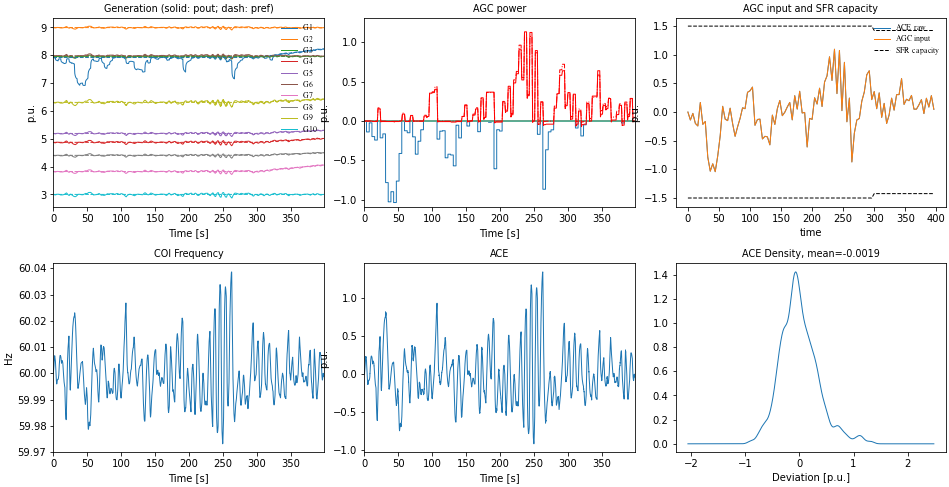

In [22]:
# color=['tab:blue', 'tab:orange', 'tab:green',
#        'tab:red', 'tab:purple']
right = end_time

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.15, hspace=0.3)

yheader = [f'G{i}' for i in range(1, 11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'], style='ieee',
                 yheader=yheader,
                 legend=True, show=False, right=right,
                 title=r'Generation (solid: pout; dash: pref)',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                 linestyles=['--'],
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'], style='ieee',
                 yheader=yheader,
                 legend=False, show=False, right=right,
                 title=r'AGC power',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 1])

# Plot EV AGC response, hard code
ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prl, color='red', linestyle='-.')
ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prcl, color='red', linestyle='-')
ax_gen[0, 1].set_ylim(top=max(sse.Prl) * 1.2)

ace_res.plot(linewidth=1,
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='ace',
             title=f'AGC input and SFR capacity')
ace_res.plot(linewidth=1,
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='in',)
ace_res.plot(linewidth=1, color='k', linestyle='--',
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='up')
ace_res.plot(linewidth=1, color='k', linestyle='--',
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='dn')
ax_gen[0, 2].set_ylabel('p.u.')
ax_gen[0, 2].legend(['ACE raw', 'AGC input', 'SFR capacity'])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'], style='ieee',
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'], style='ieee',
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE Density, mean={ace_df.ace.mean().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [p.u.]', ylabel='')


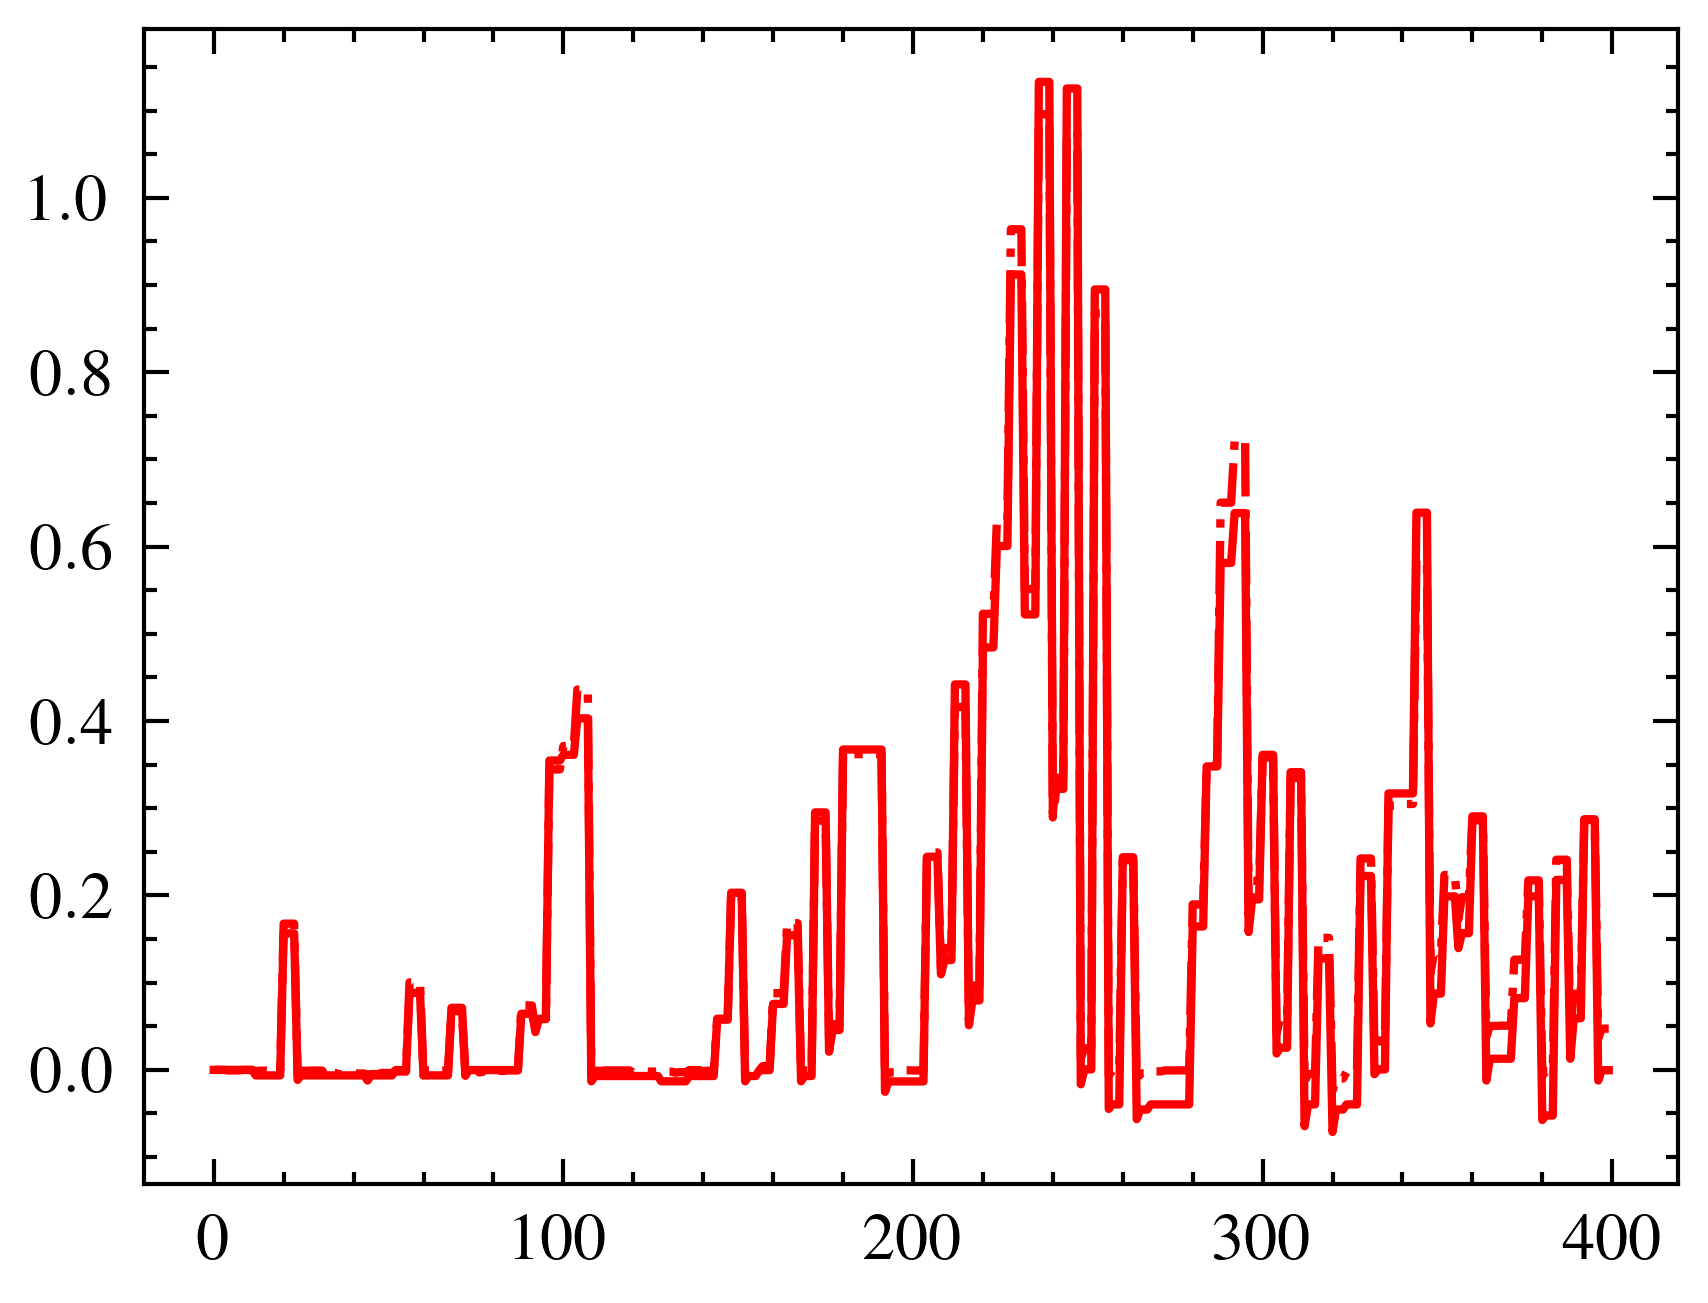

In [23]:
fige, axe = plt.subplots()
axe.plot(3600*(np.array(sse.tss)-10), sse.Prl, color='red', linestyle='-.')
axe.plot(3600*(np.array(sse.tss)-10), sse.Prcl, color='red', linestyle='-')

In [24]:
dcres

,gen,pg,pru,prd,bu,bd
0,PV_1,12.945840,0.000000,1.352075,0.0,0.950297
1,PV_2,7.120205,0.000000,0.000000,0.0,0.000000
2,PV_3,8.000000,0.000000,0.000000,0.0,0.000000
3,PV_4,5.013827,0.000000,0.000000,0.0,0.000000
4,PV_5,7.000000,0.000000,0.000000,0.0,0.000000
5,PV_6,4.800000,0.000000,0.000000,0.0,0.000000
6,PV_7,5.230592,0.000000,0.000000,0.0,0.000000
7,PV_8,7.000000,0.000000,0.000000,0.0,0.000000
8,PV_9,1.000000,0.000000,0.000000,0.0,0.000000
9,PV_10,-0.361285,1.422792,0.070717,1.0,0.049703


In [25]:
sse.report()

EVA: ts=10.1108[H], 10000 EVs, Total Q=250.12 MWh
Online 1939, Q=48.64 MWh, SoC=0.9814
Power(MW): Pt=-0.3617, Pc=-0.3617, Pd=-0.0
Ctrl: 0=1878; 1=61; 


(<Figure size 3600x1800 with 2 Axes>,
 <AxesSubplot:title={'center':'EVA'}, xlabel='Time [H]', ylabel='Power (MW)'>)

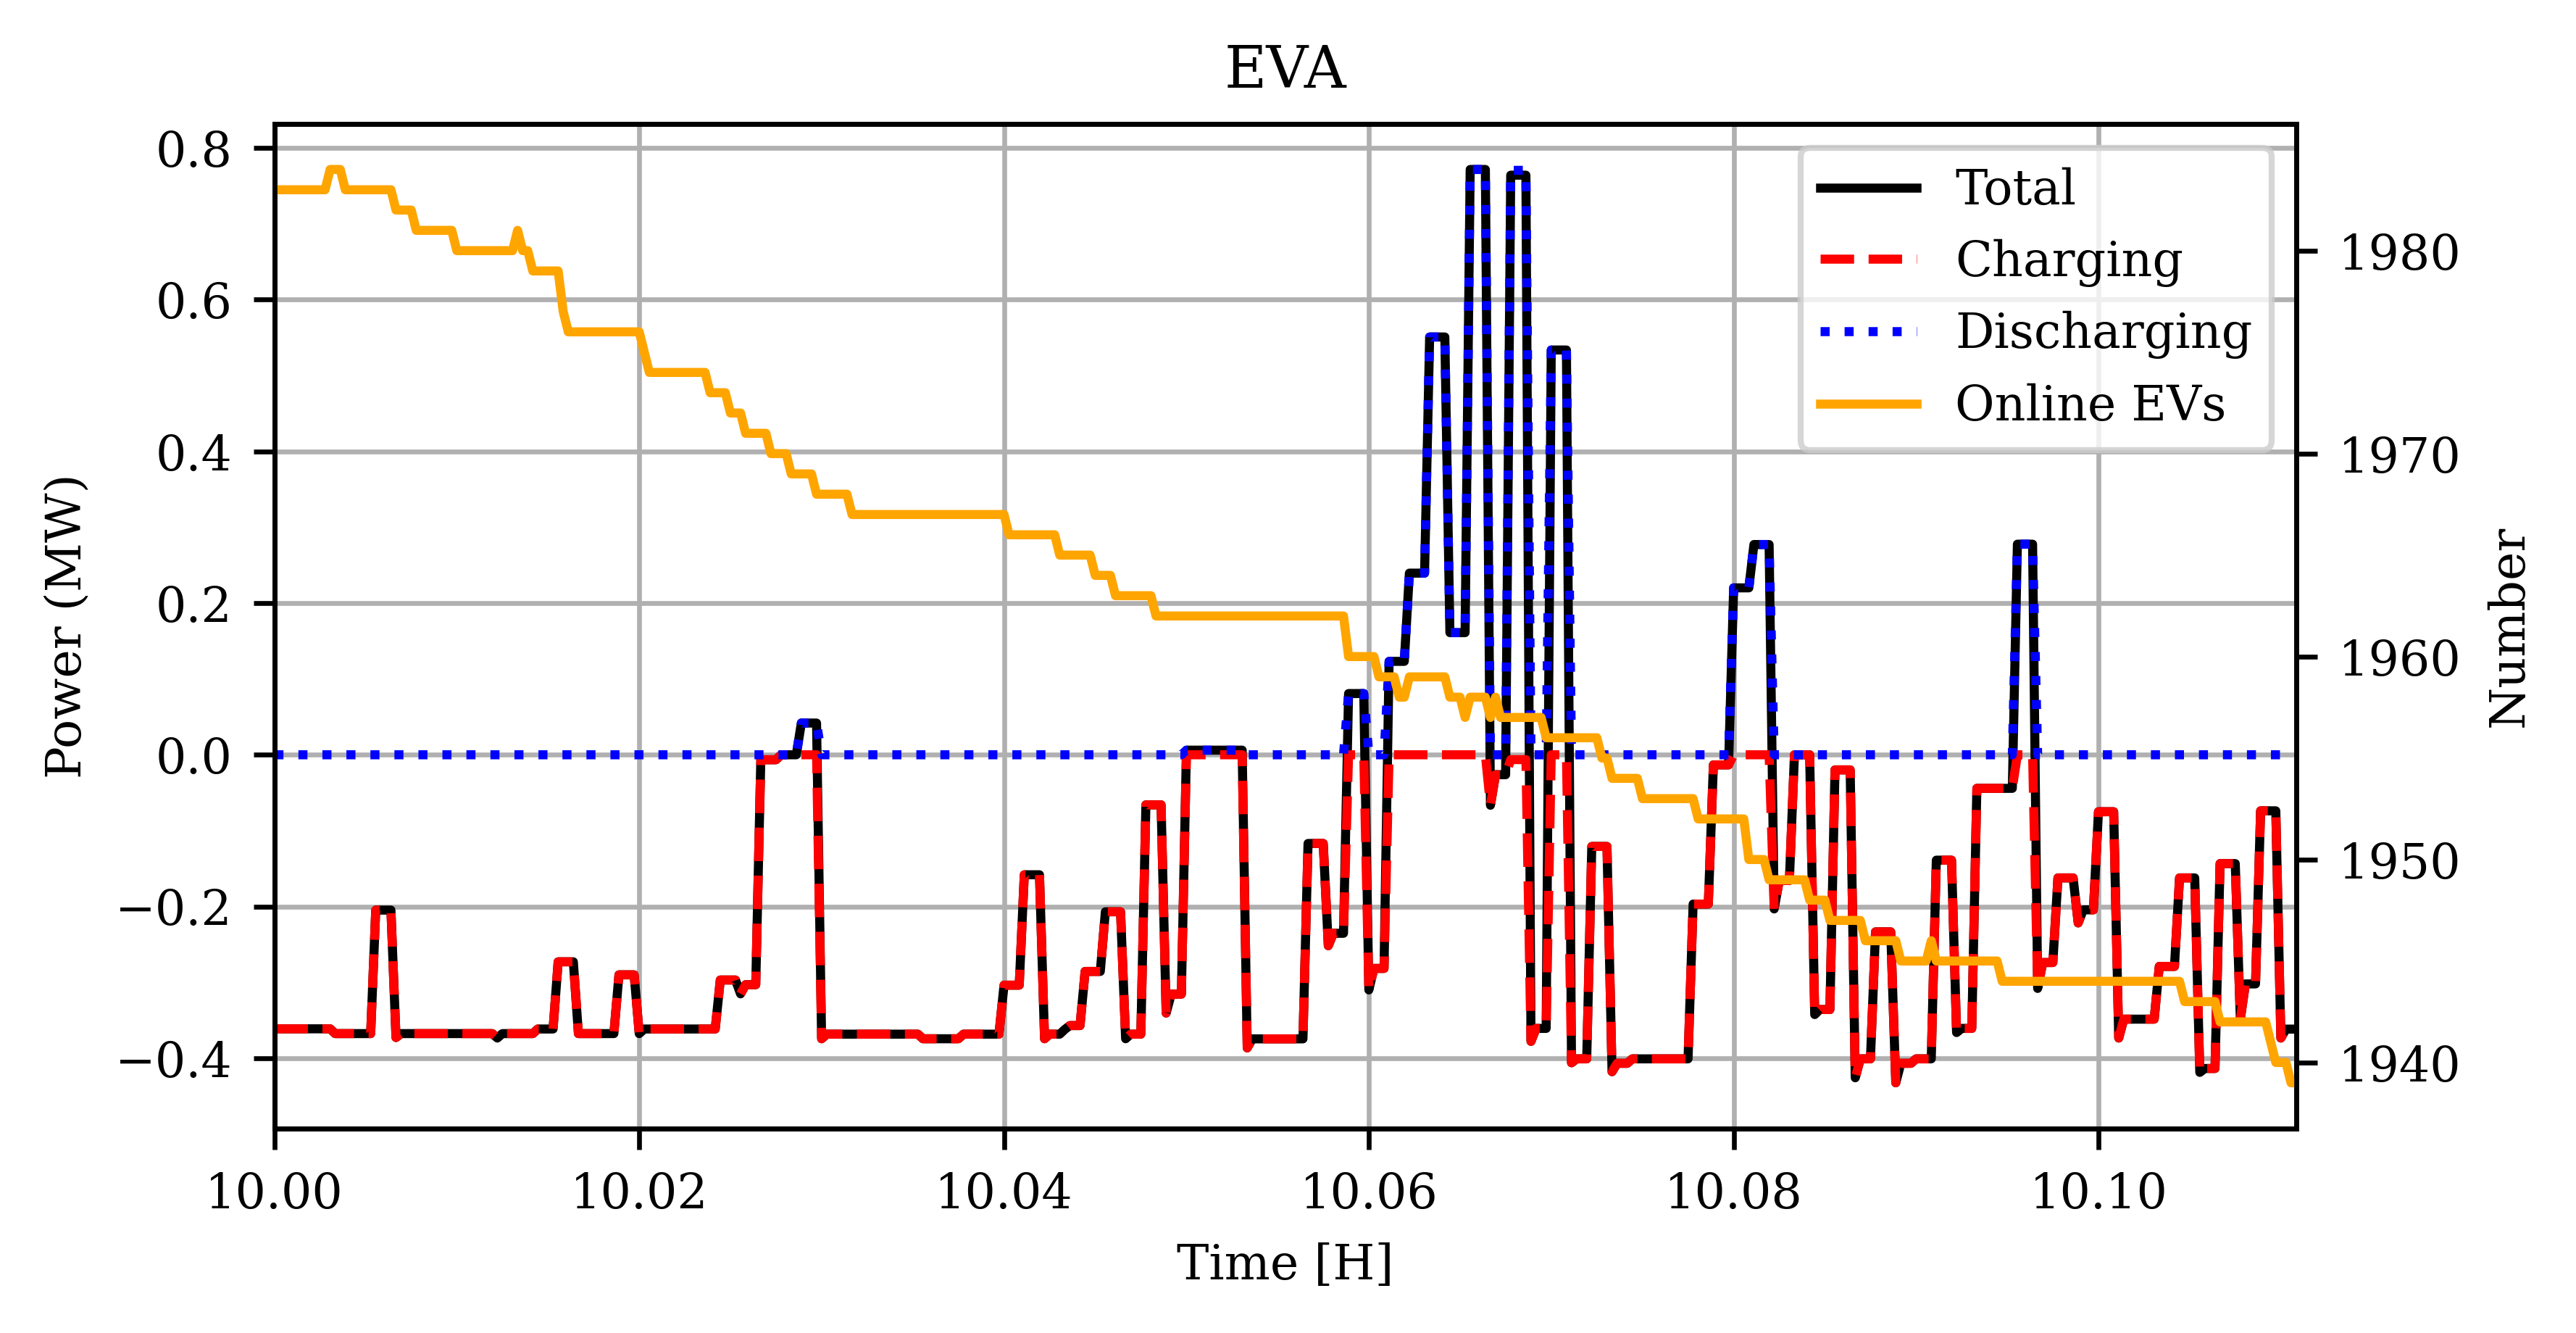

In [26]:
sse.plot()